# Toxicity Prediction Project
Final Project - Applied Case Studies of Machine Learning and Deep Learning in Key Areas 2

Bulloni Dyuman, Ippolito Manuel, Loddo Fabio - D3A

Import the required Python libraries

In [2]:
# Data handling
import pandas as pd
import numpy as np
import random
from tabulate import tabulate
import itertools

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File handling
import os
from pathlib import Path
import datetime

# RDKit modules
import rdkit as rd
from rdkit import Chem
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole

# Deep Purpose modules
from DeepPurpose import *
from DeepPurpose import ProteinPred as models
from DeepPurpose.utils import *
from DeepPurpose.dataset import *
from DeepPurpose import CompoundPred, dataset, utils

# DeepChem modules
import deepchem as dc
from deepchem.models import GraphConvModel

# ExMol modules
import exmol
import skunk

# Modeling
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve, confusion_matrix, balanced_accuracy_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

# Warnings
import warnings
warnings.filterwarnings("ignore")

import torch
from torch.utils.data import Dataset, DataLoader
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # use GPU if available

Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.
Could not import azure.core python package.


Settings

In [3]:
# Set seed value
SEED_VALUE = 124 #122 123 124, as used in MoleculeNet

# Set torch settings
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
random.seed(SEED_VALUE)
#deeppurpose.utils.seed_everything(SEED_VALUE)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

# set-up rdkit drawing preferences
IPythonConsole.ipython_useSVG = True
IPythonConsole.drawOptions.drawMolsSameScale = False

Constants

In [4]:
# Number of bits for morgan fingerprints
MORGAN_BITS = 4096

# Number of radius for morgan fingerprints
MORGAN_RADIUS = 2

## Data Exploration

Import the data

In [5]:
# Define path to the Data folder
DATA_PATH: Path = Path(os.getcwd() + "/Data")
DATA_PATH

WindowsPath('c:/Users/manue/SUPSI/Sixth Semester User/Bio Grasso/Final project/toxicity_prediction/Data')

In [6]:
# Import the clintox dataset
# Clintox dataset contains clinical toxicology data
clintox = pd.read_csv(DATA_PATH / "clintox.csv")
clintox_task = ['CT_TOX']
clintox.head()

,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0


In [7]:
# Import the tox21 dataset
# Tox21 dataset contains in vitro toxicology data 
tox21 = pd.read_csv(DATA_PATH / "tox21.csv")
tox21_tasks = ['NR-AR', 'NR-Aromatase', 'NR-PPAR-gamma', 'SR-HSE', 
               'NR-AR-LBD', 'NR-ER', 'SR-ARE', 'SR-MMP',
               'NR-AhR', 'NR-ER-LBD', 'SR-ATAD5', 'SR-p53']
tox21.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,TOX3028,CC(O)(P(=O)(O)O)P(=O)(O)O


In vivo data (that in the reference papers come from the dataset RTECS by Biovia) are not available  publicly and require a fee or a subscription to be provided, so we will work on clinical and in vitro data for this project.

### Plot data

#### Clintox dataset

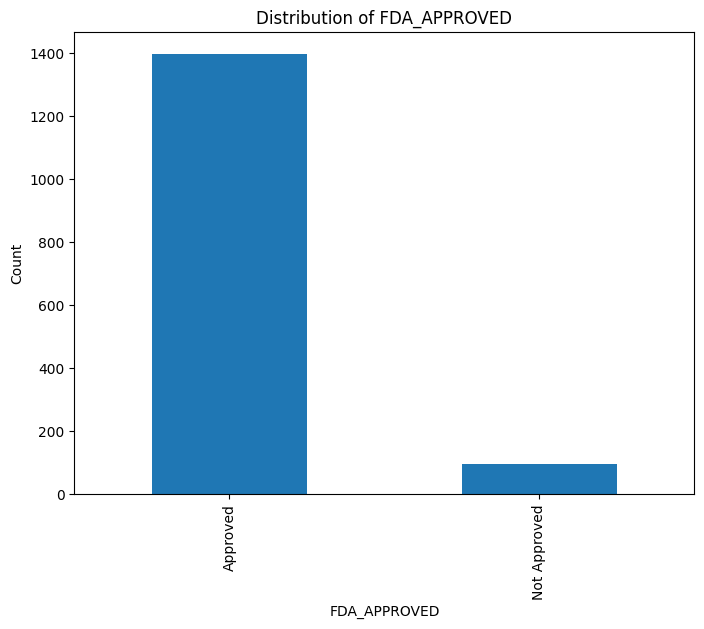

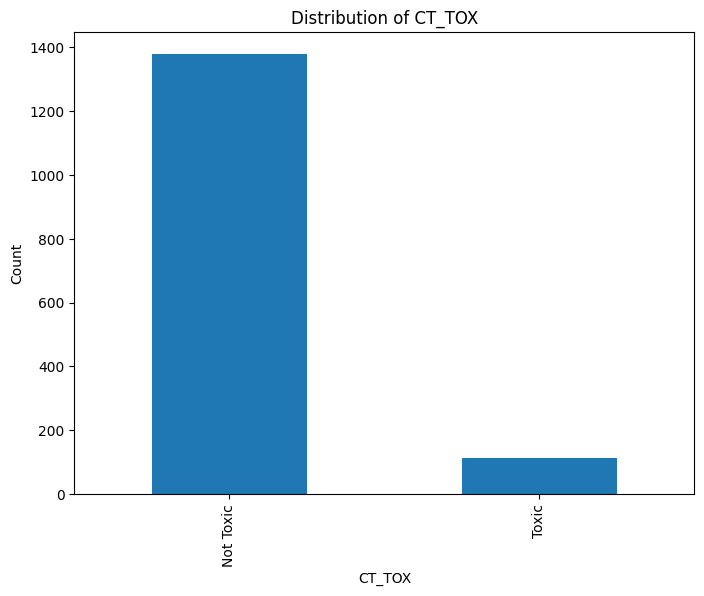

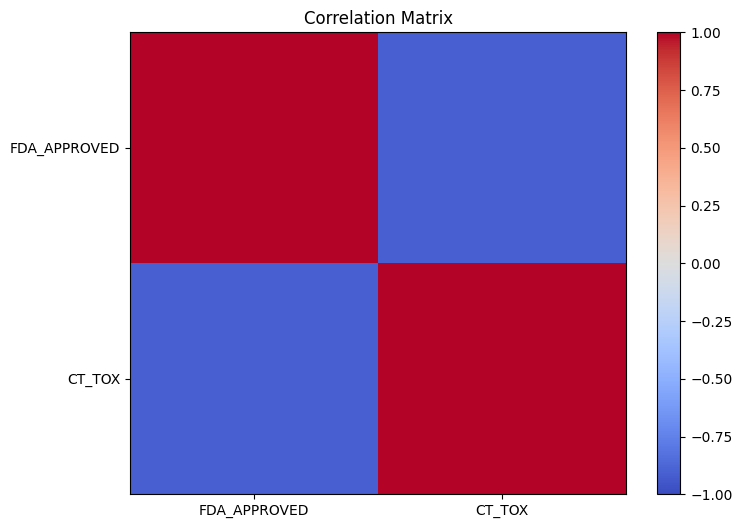

In [8]:
# Plot the distribution of FDA_APPROVED
plt.figure(figsize=(8, 6))
clintox['FDA_APPROVED'].value_counts().plot(kind='bar')
plt.title('Distribution of FDA_APPROVED')
plt.xlabel('FDA_APPROVED')
plt.ylabel('Count')
plt.xticks([0, 1], ['Approved', 'Not Approved'])
plt.show()

# Plot the distribution of CT_TOX
plt.figure(figsize=(8, 6))
clintox['CT_TOX'].value_counts().plot(kind='bar')
plt.title('Distribution of CT_TOX')
plt.xlabel('CT_TOX')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Toxic', 'Toxic'])
plt.show()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
correlation_matrix = clintox[['FDA_APPROVED', 'CT_TOX']].corr()
plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
plt.colorbar()
plt.xticks([0, 1], ['FDA_APPROVED', 'CT_TOX'])
plt.yticks([0, 1], ['FDA_APPROVED', 'CT_TOX'])
plt.title('Correlation Matrix')
plt.show()

From the distributions of CT_TOX we can see that the dataset is unbalanced, as there are way more non toxic drugs than toxic drugs in it. The same for FDA_APPROVED, we have way more FDA approved drugs than non-FDA-approved drugs in the dataset.

It seems there is a net inverse correlation between FDA_APPROVED and CT_TOX. IT makes sense that FDA approved drugs are not toxic.

## Data Pre-Processing

### Process data

In [10]:
# Remove non valid rows (SMILES that cannot be converted to Canonical SMILES)
def remove_non_valid_rows(df: pd.DataFrame) -> pd.DataFrame:
    mol_list = []
    valid_rows = []
    for i, row in df.iterrows():
        mol = Chem.MolFromSmiles(row['smiles'])
        if mol is not None:
            mol_list.append(mol)
            valid_rows.append(row)

    df = pd.DataFrame(valid_rows)
    return df

In [11]:
# Clean the database, check for redundancy and remove duplicates

# Remove duplicated rows
print('Clintox dataset dimensions with duplicates:', clintox.shape)
clintox.drop_duplicates(inplace=True) # Drop duplicated rows
print('Clintox dataset dimensions without duplicates:', clintox.shape)

# Remove non valid rows (SMILES that cannot be converted to Canonical SMILES, null SMILES, duplicated SMILES)
clintox = remove_non_valid_rows(clintox) # remove rows with non valid SMILES
clintox.drop_duplicates(subset = ['smiles'], inplace=True) # Remove duplicated canonical SMILES
clintox.dropna(subset=['smiles'], inplace=True) # Remove null SMILES
print('Clintox dataset dimensions without non valid rows:', clintox.shape)
clintox.head(3)

Clintox dataset dimensions with duplicates: (1491, 3)
Clintox dataset dimensions without duplicates: (1484, 3)
Clintox dataset dimensions without non valid rows: (1478, 3)


,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0


In [12]:
# Check for null values
clintox.isna().sum()

smiles          0
FDA_APPROVED    0
CT_TOX          0
dtype: int64

### Train-test split
In the reference papers the split of data is provided, so we'll use their same splits in order to be able to compare our results with the state-of-the-art performances.

In [18]:
### Method borrowed from MoleculeNet for random splits of 0.8 / 0.1 / 0.1, train / test / valid 
# Returns index of random train, test, valid datasets in array of [train,test,valid]
def split(dataset,
            seed=None,
            frac_train=.8,
            frac_valid=.1,
            frac_test=.1,
            log_every_n=None):
    """
    Splits internal compounds randomly into train/validation/test.
    """
    np.testing.assert_almost_equal(frac_train + frac_valid + frac_test, 1.)
    if not seed is None:
        np.random.seed(seed)
    num_datapoints = len(dataset)
    train_cutoff = int(frac_train * num_datapoints)
    valid_cutoff = int((frac_train + frac_valid) * num_datapoints)
    shuffled = np.random.permutation(range(num_datapoints))
    return (shuffled[:train_cutoff], shuffled[train_cutoff:valid_cutoff],
            shuffled[valid_cutoff:])

In [19]:
# Split the Clintox dataset into train-test-validation sets with ratios 0.8/0.1/0.1
train_indices, test_indices, valid_indices = split(clintox, frac_train=0.8, frac_valid=0.1, frac_test=0.1)  # Use random seed from MoleculeNet

clintox_train = clintox.iloc[train_indices]
clintox_test = clintox.iloc[test_indices]
clintox_val = clintox.iloc[valid_indices]

clintox_data = [clintox_train, clintox_test, clintox_val]


In [20]:
# Check the number of samples in each set
print("Total number of samples, train: " + str(clintox_data[0].shape[0]))
print("Total number of samples, test: " + str(clintox_data[1].shape[0]))
print("Total number of samples, valid: " + str(clintox_data[2].shape[0]))
print("Total number of samples, train+test+valid: " + str(clintox_data[0].shape[0] + 
                                                           clintox_data[1].shape[0] + 
                                                           clintox_data[2].shape[0]))

Total number of samples, train: 1182
Total number of samples, test: 148
Total number of samples, valid: 148
Total number of samples, train+test+valid: 1478


## Modelling

#### Construct Morgan fingerprints

In [23]:
CLINTOX_TARGET = 'CT_TOX'

In [24]:
# Save a copy of train-test-val splits before adding informations
clintox_df = []
clintox_df.append(clintox_data[0].copy())
clintox_df.append(clintox_data[1].copy())
clintox_df.append(clintox_data[2].copy())

In [25]:
# Check clintox_data
clintox_data[0].head(3)

,smiles,FDA_APPROVED,CT_TOX
755,CC(C)CN(C[C@H]([C@H](Cc1ccccc1)NC(=O)O[C@H]2CC...,1,0
96,C1[C@H](C(=O)NO1)[NH3+],1,0
671,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,0,1


In [26]:
# Construct morgan fingerprints 
for i in range(len(clintox_data)):
    clintox_data[i]['mol'] = [rd.Chem.MolFromSmiles(x) for x in clintox_data[i]['smiles']]

    bi = [{} for _ in range(len(clintox_data[i]))]
    clintox_data[i]['morgan'] = [AllChem.GetMorganFingerprintAsBitVect(clintox_data[i].iloc[j]['mol'], MORGAN_RADIUS, nBits = MORGAN_BITS, bitInfo=bi[j]) 
                         for j in range(len(clintox_data[i]))]
    clintox_data[i]['bitInfo'] = bi

In [27]:
# Check clintox_data
clintox_data[0].head(3)

,smiles,FDA_APPROVED,CT_TOX,mol,morgan,bitInfo
755,CC(C)CN(C[C@H]([C@H](Cc1ccccc1)NC(=O)O[C@H]2CC...,1,0,<rdkit.Chem.rdchem.Mol object at 0x000002049B9...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{32: ((18, 2),), 117: ((15, 1),), 119: ((19, 1..."
96,C1[C@H](C(=O)NO1)[NH3+],1,0,<rdkit.Chem.rdchem.Mol object at 0x000002049B9...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{656: ((5, 0),), 1124: ((6, 1),), 1380: ((2, 0..."
671,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,0,1,<rdkit.Chem.rdchem.Mol object at 0x000002049B9...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{45: ((21, 1),), 58: ((8, 2),), 204: ((27, 2),..."


In [28]:
# Split data into training, testing and valuidation sets
train_data = clintox_data[0]
test_data  = clintox_data[1]
valid_data = clintox_data[2]

#### Arrays for train / test / valid sets used for DNN 

In [29]:
# convert the RDKit explicit vectors into numpy arrays
x_train = []
for fp in train_data['morgan']:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    x_train.append(arr)
x_train = np.array(x_train)
x_train = x_train - 0.5

y_train = train_data[clintox_task].values


# convert the RDKit explicit vectors into numpy arrays
x_test = []
for fp in test_data['morgan']:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    x_test.append(arr)
x_test = np.array(x_test)
x_test = x_test - 0.5

y_test = test_data[clintox_task].values


# convert the RDKit explicit vectors into numpy arrays
x_valid = []
for fp in valid_data['morgan']:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    x_valid.append(arr)
x_valid = np.array(x_valid)
x_valid = x_valid - 0.5

y_valid = valid_data[clintox_task].values

In [30]:
# count the number of data points per class
N_train = np.sum(y_train >= 0, 0)
N_test  = np.sum(y_test >= 0, 0)
N_valid  = np.sum(y_valid >= 0, 0)

#### Reference models

##### STDNN (From https://github.com/IBM/multitask-toxicity/tree/main)

In [31]:
# Parameters for the model 
train_epoch = 50 
batch = 512 

In [32]:
# convert data for pytorch
x_train_torch = x_train.astype(np.float32)
y_train_torch = y_train.astype(np.float32)

x_test_torch = x_test.astype(np.float32)
y_test_torch = y_test.astype(np.float32)

x_valid_torch = x_valid.astype(np.float32)
y_valid_torch = y_valid.astype(np.float32)

In [33]:
input_shape = x_train_torch.shape[1]
input_shape

4096

In [34]:
# Class for STDNN data
class STDNNData(Dataset):

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [35]:
training_set = STDNNData(x_train_torch, y_train_torch)
training_generator = DataLoader(training_set, batch_size=batch, shuffle=True)

testing_set = STDNNData(x_test_torch, y_test_torch)
testing_generator = DataLoader(testing_set, batch_size=len(testing_set), shuffle=False)

valid_set = STDNNData(x_valid_torch, y_valid_torch)
valid_generator = DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

In [36]:
# STDNN Model class
# For each task (1 only in ClinTox), creates 2 hidden layers 

class STDNN(torch.nn.Module):
    def __init__(self, input_shape, all_tasks):
        super(STDNN, self).__init__()

        self.hidden_3 = torch.nn.ModuleList([torch.nn.Linear(input_shape, 1024) for task in all_tasks])
        self.batchnorm_3 = torch.nn.ModuleList([torch.nn.BatchNorm1d(1024) for task in all_tasks])
       
        self.hidden_4 = torch.nn.ModuleList([torch.nn.Linear(1024, 512) for task in all_tasks])
        self.batchnorm_4 = torch.nn.ModuleList([torch.nn.BatchNorm1d(512) for task in all_tasks])
        
        self.output   = torch.nn.ModuleList([torch.nn.Linear(512, 1) for task in all_tasks])
        
        # function for leaky ReLU
        self.leakyReLU = torch.nn.LeakyReLU(0.05)

    def forward(self, x):        
        x_task = [None for i in range(len(self.output))]  # initialize
        for task in range(len(self.output)):
            x_task[task] = self.hidden_3[task](x)
            x_task[task] = self.batchnorm_3[task](x_task[task])
            x_task[task] = self.leakyReLU(x_task[task])
            
            x_task[task] = self.hidden_4[task](x_task[task])
            x_task[task] = self.batchnorm_4[task](x_task[task])
            x_task[task] = self.leakyReLU(x_task[task])
            
            x_task[task] = self.output[task](x_task[task])
            x_task[task] = torch.sigmoid(x_task[task])
        
        y_pred = x_task
        
        return y_pred
    
model_stdnn = STDNN(input_shape, clintox_task).to(device)

In [37]:
# Define the loss
criterion = torch.nn.BCELoss()

# Optimizers require the parameters to optimize and a learning rate
optimizer = torch.optim.Adam(model_stdnn.parameters(), lr = 0.001)

In [38]:
loss_history=[]  
correct_history=[]  
val_loss_history=[]  
val_correct_history=[] 
train_loss_min = np.Inf
val_loss_min = np.Inf


# Training
for e in range(train_epoch):
    
    model_stdnn.train()
    # keep track of the loss over an epoch
    running_train_loss = 0
    running_valid_loss = 0
    running_train_correct = 0
    running_val_correct = 0
    y_train_true = []
    y_train_pred = []
    y_valid_true = []
    y_valid_pred = []
    batch = 0
    for x_batch, y_batch in training_generator:
        batch += 1
        if torch.cuda.is_available():
            x_batch, y_batch = x_batch.cuda(), y_batch.cuda() 
        
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model_stdnn(x_batch)  # for all tasks
        
        # Compute loss over all tasks
        loss = 0
        correct = 0
        y_train_true_task = []
        y_train_pred_task = []
        for i in range(len(clintox_task)):
            y_batch_task = y_batch[:,i]
            y_pred_task  = y_pred[i][:,0] #check if predictions na
            
            # compute loss for labels that are not NA
            indice_valid = y_batch_task >= 0
            loss_task = criterion(y_pred_task[indice_valid], y_batch_task[indice_valid]) / N_train[i]
            
            loss += loss_task

            pred_train = np.round(y_pred_task[indice_valid].detach().cpu().numpy())
            target_train = y_batch_task[indice_valid].float()
            y_train_true.extend(target_train.tolist()) 
            y_train_pred.extend(pred_train.reshape(-1).tolist())

        # Zero gradients, perform a backward pass, and update the weights.
        # writer.add_scalar("Accuracy/train", loss, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # sum up the losses from each batch
        running_train_loss += loss.item()
        # writer.add_scalar("Loss/train", running_train_loss, e)
        
    else:
        with torch.no_grad():    
        ## evaluation part 
            model_stdnn.eval()
            for val_x_batch, val_y_batch in valid_generator:
                
                if torch.cuda.is_available():
                    val_x_batch, val_y_batch = val_x_batch.cuda(), val_y_batch.cuda() 
                
                val_output = model_stdnn(val_x_batch)

                ## 2. loss calculation over all tasks 
                val_loss = 0
                val_correct = 0
                y_valid_true_task = []
                y_valid_pred_task = []
                for i in range(len(clintox_task)):
                    val_y_batch_task = val_y_batch[:,i]
                    val_output_task  = val_output[i][:,0]

                    # compute loss for labels that are not NA
                    indice_valid = val_y_batch_task >= 0
                    val_loss_task = criterion(val_output_task[indice_valid], val_y_batch_task[indice_valid]) / N_valid[i]

                    val_loss += val_loss_task
                    
                    pred_valid = np.round(val_output_task[indice_valid].detach().cpu().numpy())
                    target_valid = val_y_batch_task[indice_valid].float()
                    y_valid_true.extend(target_valid.tolist()) 
                    y_valid_pred.extend(pred_valid.reshape(-1).tolist())
                
                #writer.add_scalar("Loss/valid", val_loss, batch)

                running_valid_loss+=val_loss.item()
                # writer.add_scalar("Loss/valid", running_valid_loss, e)
        
        #epoch loss
        train_epoch_loss=np.mean(running_train_loss)
        val_epoch_loss=np.mean(running_valid_loss)  
       
        #epoch accuracy      
        train_epoch_acc = accuracy_score(y_train_true,y_train_pred)
        val_epoch_acc = accuracy_score(y_valid_true,y_valid_pred)
        
        #history
        loss_history.append(train_epoch_loss)  
        correct_history.append(train_epoch_acc)
        val_loss_history.append(val_epoch_loss)  
        val_correct_history.append(val_epoch_acc)  
        
        print("Epoch:", e, "Training Loss:", train_epoch_loss, "Valid Loss:", val_epoch_loss)
        print("Training Acc:", train_epoch_acc, "Valid Acc:", val_epoch_acc)

Epoch: 0 Training Loss: 0.0016221222467720509 Valid Loss: 0.004662106744945049
Training Acc: 0.5693739424703892 Valid Acc: 0.7162162162162162
Epoch: 1 Training Loss: 0.0008044223359320313 Valid Loss: 0.004439052194356918
Training Acc: 0.9094754653130288 Valid Acc: 0.8986486486486487
Epoch: 2 Training Loss: 0.0004632657946785912 Valid Loss: 0.002849081763997674
Training Acc: 0.9763113367174281 Valid Acc: 0.9054054054054054
Epoch: 3 Training Loss: 0.0002634546617628075 Valid Loss: 0.002616934012621641
Training Acc: 0.9771573604060914 Valid Acc: 0.8918918918918919
Epoch: 4 Training Loss: 0.00019393051479710266 Valid Loss: 0.00343285221606493
Training Acc: 0.9847715736040609 Valid Acc: 0.9054054054054054
Epoch: 5 Training Loss: 0.0001417616913386155 Valid Loss: 0.006319101434201002
Training Acc: 0.9847715736040609 Valid Acc: 0.12162162162162163
Epoch: 6 Training Loss: 0.00012231578875798732 Valid Loss: 0.007797684986144304
Training Acc: 0.9847715736040609 Valid Acc: 0.10810810810810811
Epo

In [39]:
# print test loss
for x_test_torch, y_test_torch in testing_generator:
    y_test_pred = model_stdnn.eval().to(device).cpu()(x_test_torch)
    
    # Compute loss over all tasks
    loss = 0
    for i in range(len(clintox_task)):
        y_test_task = y_test_torch[:,i]
        y_pred_task  = y_test_pred[i][:,0]

        # compute loss for labels that are not NA
        indice_valid = y_test_task >= 0
        loss_task = criterion(y_pred_task[indice_valid], y_test_task[indice_valid]) / N_test[i]

        loss += loss_task
    
print(loss.item())

0.002651843475177884


Accuracy for STDNN on Morgan Fingerprint: 0.9054054054054054
Balanced Accuracy for STDNN on Morgan Fingerprint: 0.6553571428571429
F1 for STDNN on Morgan Fingerprint: 0.3
 True Positive: 0.375
 True Negative: 0.9357142857142857
False Positive: 0.06428571428571428
False Negative: 0.625
Test ROC AUC (CT_TOX): 0.6660714285714285


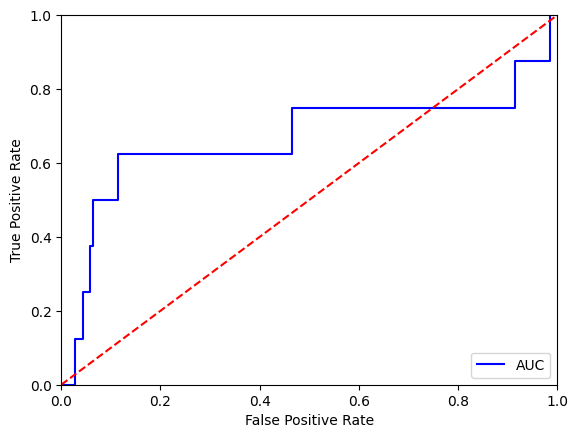

In [40]:
results = {}
# Collects performance metrics for all tasks on test set
for i in range(len(clintox_task)):
    
    valid_datapoints = y_test[:,i] >= 0
    y_test_task = y_test[valid_datapoints,i] 
    y_test_pred_task = y_test_pred[i].detach().numpy()[valid_datapoints,0]
    
    acc = accuracy_score(y_test_task, np.round(y_test_pred_task))
    print('Accuracy for STDNN on Morgan Fingerprint:', acc)
    
    bacc = sklearn.metrics.balanced_accuracy_score(y_test_task, np.round(y_test_pred_task))
    print('Balanced Accuracy for STDNN on Morgan Fingerprint:', bacc)

    f1 = f1_score(y_test_task, np.round(y_test_pred_task), pos_label=1)
    print('F1 for STDNN on Morgan Fingerprint:', f1)

    cfm = sklearn.metrics.confusion_matrix(y_test_task, np.round(y_test_pred_task))
    cfm = cfm.astype('float') / cfm.sum(axis=1)[:, np.newaxis]
    
    tn, fp, fn, tp = cfm.ravel()
    pr = tp / (tp + fp)
    rc = tp / (tp + fn)
    print(' True Positive:', tp)
    print(' True Negative:', tn)
    print('False Positive:', fp)
    print('False Negative:', fn)
    
    
    auc = roc_auc_score(y_test_task, y_test_pred_task)
    print('Test ROC AUC ({}):'.format(clintox_task[i]), auc)
    
    results[clintox_task[i]] = [auc, acc, bacc, tn, tp, pr, rc, f1]

    fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test_task, y_test_pred_task)
    plt.plot(fpr, tpr, 'b', label = 'AUC')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Here we have the same results obtained by the reference paper using their model and data splits.

We'll try to improve the performances using the same data splits.

##### GCNN (Using DeepChem )

In [41]:
# Function to evaluate model performances
def evaluate_deepchem(y_true, y_pred):
    # Convert continuous targets to binary targets using a threshold of 0.5
    y_true_binary = y_true
    y_pred_binary = y_pred

    print(y_true_binary.shape, y_pred_binary.shape)

    # Calculate evaluation metrics on binary targets
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)
    roc_auc = roc_auc_score(y_true, y_pred)
    conf_mat = confusion_matrix(y_true_binary, y_pred_binary)
    bacc = balanced_accuracy_score(y_true_binary, y_pred_binary)

    # Create a list of metric names and values
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC", "Balanced Accuracy"]
    values = [accuracy, precision, recall, f1, roc_auc, bacc]

    # Create a list of lists for tabulating
    table = [metrics, values]

    # Display the table
    print(tabulate(table, headers='firstrow'))

    # Create a heatmap of the confusion matrix
    sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])

    # Add labels and title
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

In [42]:
# Create features for the Graph Neural Network
def featurize(data, tasks):
    # Extract the smiles and target columns
    smiles = data['smiles'].values
    targets = data[tasks].values

    # Define the featurizer
    featurizer = dc.feat.graph_features.ConvMolFeaturizer()

    # Featurize the molecules
    mols = [Chem.MolFromSmiles(smile) for smile in smiles]
    featurized_mols = featurizer.featurize(mols)

    # Convert the dataset to DeepChem's NumpyDataset format
    dataset = dc.data.NumpyDataset(X=featurized_mols, y=targets)

    return dataset

In [43]:
# Get data with features for the GCNN
train, valid, test = [featurize(data, CLINTOX_TARGET) for data in [train_data, valid_data, test_data]]

In [44]:
# Define the model
model = dc.models.GraphConvModel(
    len(clintox_task),
    batch_size=512,
    mode='classification',
    n_classes=2,
)

# Train the model for 50 epochs
num_epochs = 50
losses = []
for i in range(num_epochs):
    loss = model.fit(train, nb_epoch=1)
    print("Epoch %d loss: %f" % (i+1, loss))
    losses.append(loss)

Epoch 1 loss: 0.852252
Epoch 2 loss: 0.392372
Epoch 3 loss: 0.233554
Epoch 4 loss: 0.184809
Epoch 5 loss: 0.167725
Epoch 6 loss: 0.154287
Epoch 7 loss: 0.143647
Epoch 8 loss: 0.132300
Epoch 9 loss: 0.120191
Epoch 10 loss: 0.111773
Epoch 11 loss: 0.101905
Epoch 12 loss: 0.097331
Epoch 13 loss: 0.089674
Epoch 14 loss: 0.083609
Epoch 15 loss: 0.080108
Epoch 16 loss: 0.074054
Epoch 17 loss: 0.069529
Epoch 18 loss: 0.067272
Epoch 19 loss: 0.064075
Epoch 20 loss: 0.060496
Epoch 21 loss: 0.057836
Epoch 22 loss: 0.056146
Epoch 23 loss: 0.053257
Epoch 24 loss: 0.053376
Epoch 25 loss: 0.049233
Epoch 26 loss: 0.047098
Epoch 27 loss: 0.045571
Epoch 28 loss: 0.044572
Epoch 29 loss: 0.042504
Epoch 30 loss: 0.041753
Epoch 31 loss: 0.040360
Epoch 32 loss: 0.039216
Epoch 33 loss: 0.037942
Epoch 34 loss: 0.032078
Epoch 35 loss: 0.036583
Epoch 36 loss: 0.035259
Epoch 37 loss: 0.033769
Epoch 38 loss: 0.033377
Epoch 39 loss: 0.032038
Epoch 40 loss: 0.031093
Epoch 41 loss: 0.031172
Epoch 42 loss: 0.029406
E

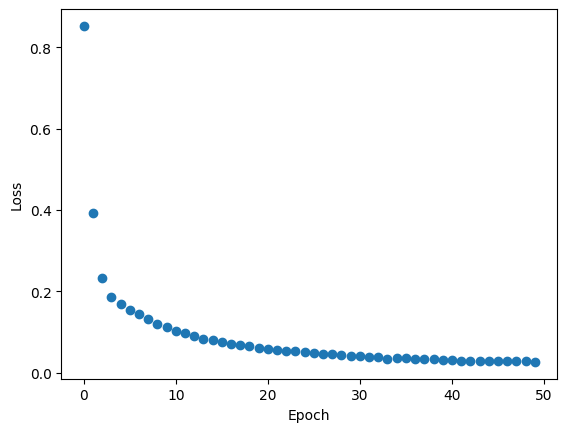

In [45]:
# Plot loss over epochs
plt.ylabel("Loss")
plt.xlabel("Epoch")
x = range(num_epochs)
y = losses
plt.scatter(x, y)
plt.show()

(148,) (148,)
  Accuracy    Precision    Recall    F1 Score    ROC AUC    Balanced Accuracy
----------  -----------  --------  ----------  ---------  -------------------
  0.939189            0         0           0   0.496429             0.496429


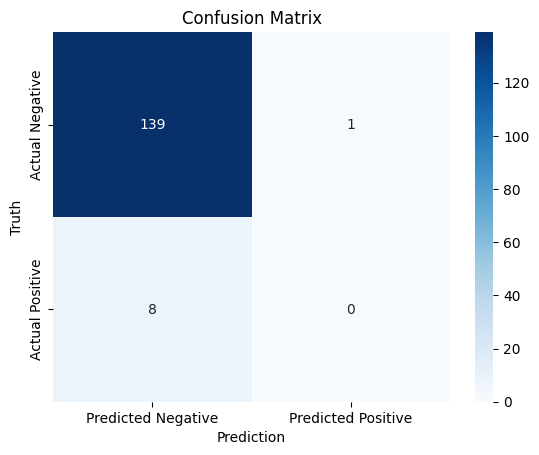

In [46]:
# Manipulate the data to use our scoring function
y_test = test.to_dataframe()['y'].values
y_pred = model.predict(test).reshape((148, 2))
y_test_binary = (y_test > 0.5).astype(int)

arg_m = np.argmax(y_pred, axis=1)
y_pred_binary = np.where(arg_m > 0.5, 1, 0)

# Evaluate the model
evaluate_deepchem(y_test_binary, y_pred_binary)

The results obtained from the base GCNN are not very promising if compared to the ones from the STDNN and from the ones found on the reference papers.

#### Deep Purpose

In [47]:
# Function to evaluate model performances
def evaluate_model(model, test):
    y_true = np.array(test['Label'])
    y_pred = np.array(model.predict(test))

    # Convert continuous targets to binary targets using a threshold of 0.5
    y_true_binary = (y_true > 0.5).astype(int)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate evaluation metrics on binary targets
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)
    roc_auc = roc_auc_score(y_true, y_pred)
    conf_mat = confusion_matrix(y_true_binary, y_pred_binary)
    bacc = balanced_accuracy_score(y_true_binary, y_pred_binary)

    # Create a list of metric names and values
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC", "Balanced Accuracy"]
    values = [accuracy, precision, recall, f1, roc_auc, bacc]

    # Create a list of lists for tabulating
    table = [metrics, values]

    # Display the table
    print(tabulate(table, headers='firstrow'))

    # Create a heatmap of the confusion matrix
    sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])

    # Add labels and title
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

In [48]:
# Get X and y for train, test, val splits
X_train = train_data['smiles']
y_train = train_data[CLINTOX_TARGET]

X_test = test_data['smiles']
y_test = test_data[CLINTOX_TARGET]

X_valid = valid_data['smiles']
y_valid = valid_data[CLINTOX_TARGET]

In [49]:
def train_model(X_train, y_train, X_test, y_test, X_valid, y_valid, drug_encoding='Morgan'):
    # Get fingerprints for train, test, val splits
    train = utils.data_process(X_drug=X_train, y=y_train, drug_encoding=drug_encoding, split_method='no_split', random_seed=SEED_VALUE)
    val = utils.data_process(X_drug=X_valid, y=y_valid, drug_encoding=drug_encoding, split_method='no_split', random_seed=SEED_VALUE)
    test = utils.data_process(X_drug=X_test, y=y_test, drug_encoding=drug_encoding, split_method='no_split', random_seed=SEED_VALUE)

    # Configuring the model
    config = utils.generate_config(drug_encoding=drug_encoding, mlp_hidden_dims_drug=[32, 16, 8], train_epoch=40, LR=0.001, batch_size=124)

    model_dp = CompoundPred.model_initialize(**config)

    # Training the model
    print('\n\n', '-' * 30)
    print(f'Model training using {drug_encoding} fingerprint:')
    model_dp.train(train, val, test, verbose=1)

    # Evaluating the model
    evaluate_model(model_dp, test)
    print('-' * 30)


In [50]:
# Test DeepPurpode models using different drug encodings (seen in class)
# drug_encodings = ['Morgan', 'Pubchem', 'Daylight', 'rdkit_2d_normalized']

# [train_model(X_train, y_train, X_test, y_test, X_valid, y_valid, encoding) for encoding in drug_encodings]

The best fingerprint, between the ones seen in class, in general seems to be Morgan fingerprint

In [51]:
# Test DeepPurpode models using different drug encodings (not seen in class)
# drug_encodings = ['ESPF', 'ErG', 'CNN', 'Transformer']

# [train_model(X_train, y_train, X_test, y_test, X_valid, y_valid, encoding) for encoding in drug_encodings]

ESPF and CNN drug encodings work really well, with the CNN drug encoding working incredibly well!

We reached scores very close to the best ones reported in the reference paper but without adding any feature and using just data from Clintox dataset.

The Transformer drug encoding seems to be so complex that it just overfits the training data.

##### Add Features from RDkit

In [52]:
# Split data into training, testing and valuidation sets
train_data = clintox_df[0]
test_data  = clintox_df[1]
valid_data = clintox_df[2]

In [53]:
#Calculating LogP, MW, RB, AromaticAtoms, HeavyAtoms, AP  descriptors
def compute_descriptors(df):
    dfc = df.copy()
    dfc["ROMol"] = dfc["smiles"].apply(lambda x: Chem.MolFromSmiles(x))
    dfc['MolLogP'] = [Descriptors.MolLogP(mol) for mol in dfc['ROMol']]
    dfc['RB'] =  [Descriptors.NumRotatableBonds(mol) for mol in dfc['ROMol']]
    dfc['cLogP'] = [Descriptors.MolWt(mol) for mol in dfc['ROMol']]
    dfc['ExactMolWt'] = [Descriptors.ExactMolWt(mol) for mol in dfc['ROMol']]
    dfc['NumRotatableBonds'] = [Descriptors.NumRotatableBonds(mol) for mol in dfc['ROMol']]
    dfc['MolWt'] = [Descriptors.MolWt(mol) for mol in dfc['ROMol']]
    dfc['AromaticAtoms'] = [len(mol.GetAromaticAtoms()) for mol in dfc['ROMol']]
    dfc['HeavyAtoms'] = [mol.GetNumHeavyAtoms() for mol in dfc['ROMol']]
    dfc['AP'] = dfc['AromaticAtoms'] / dfc['HeavyAtoms']
    
    return dfc

In [54]:
# Compute features on the already splitted data
train_features, test_features, valid_features = [compute_descriptors(data) for data in [train_data, test_data, valid_data]]

In [55]:
# Check the sets with the new features
train_features.head(3)

,smiles,FDA_APPROVED,CT_TOX,ROMol,MolLogP,RB,cLogP,ExactMolWt,NumRotatableBonds,MolWt,AromaticAtoms,HeavyAtoms,AP
755,CC(C)CN(C[C@H]([C@H](Cc1ccccc1)NC(=O)O[C@H]2CC...,1,0,<rdkit.Chem.rdchem.Mol object at 0x00000205A65...,2.40280,11,505.637,505.224657,11,505.637,12,35,0.342857
96,C1[C@H](C(=O)NO1)[NH3+],1,0,<rdkit.Chem.rdchem.Mol object at 0x00000205A65...,-2.34170,0,103.101,103.050204,0,103.101,0,7,0.000000
671,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,0,1,<rdkit.Chem.rdchem.Mol object at 0x00000205A65...,5.89378,3,469.548,469.190260,3,469.548,29,36,0.805556


In [56]:
# Get X and y for train, test, val splits
features = ['smiles', 'FDA_APPROVED', 'ROMol', 'MolLogP', 'RB', 'cLogP',
                         'ExactMolWt', 'NumRotatableBonds', 'MolWt', 'AromaticAtoms',
                         'HeavyAtoms', 'AP']

X_train = train_features[features]
y_train = train_features[CLINTOX_TARGET]

X_test = test_features[features]
y_test = test_features[CLINTOX_TARGET]

X_valid = valid_features[features]
y_valid = valid_features[CLINTOX_TARGET]

In [57]:
# Concatenate the features to make them compatible with DeepPurpose
X_train_c = np.concatenate([X_train['smiles']] + [X_train.drop(['smiles', 'ROMol'], axis=1).values.flatten()], axis=0)
X_test_c = np.concatenate([X_test['smiles']] + [X_test.drop(['smiles', 'ROMol'], axis=1).values.flatten()], axis=0)
X_valid_c = np.concatenate([X_valid['smiles']] + [X_valid.drop(['smiles', 'ROMol'], axis=1).values.flatten()], axis=0)

In [58]:
# # Train the DeepPurpose model using all the new features
# drug_encodings = ['Morgan', 'Pubchem', 'Daylight', 'rdkit_2d_normalized', 'ESPF', 'ErG', 'CNN', 'Transformer']

# [train_model(X_train_c, y_train, X_test_c, y_test, X_valid_c, y_valid, encoding) for encoding in drug_encodings]

As seen in the test with the models using just smiles as features, the best drug encodings seem to be ESPF and CNN, with CNN as the best one.

It seems that adding these features didn't improve the results.

We'll try to perform feature selection to see if we can remove some confounder features and improve the results obtained just from using the smiles.

##### Features Selection

In [59]:
# Get again X and y for train, test, val splits
X_train = train_features[features]
y_train = train_features[CLINTOX_TARGET]

X_test = test_features[features]
y_test = test_features[CLINTOX_TARGET]

X_valid = valid_features[features]
y_valid = valid_features[CLINTOX_TARGET]

In [60]:
# Try feature selection stuff
# Separate the target variable (if applicable)
def feature_selection(X_train, X_test, X_valid, y_train, y_test, y_valid, num_features=3):
    data_x, data_y = [X_train, X_test, X_valid], [y_train, y_test, y_valid]

    x1, x2, x3, y1 = data_x[0].copy(),  data_x[1].copy(), data_x[2].copy(), data_y[0].copy()

    # Remove the 'smiles'  and 'ROMol' columns from features
    x1 = x1.drop(['smiles', 'ROMol'], axis=1)  
    x2 = x2.drop(['smiles', 'ROMol'], axis=1) 
    x3 = x3.drop(['smiles', 'ROMol'], axis=1) 

    # Create a RandomForestRegressor as the estimator for RFE
    estimator = RandomForestRegressor()

    # Perform Recursive Feature Elimination (RFE)
    rfe = RFE(estimator, n_features_to_select=num_features)  # Select the top num_features features
    X_selected = rfe.fit_transform(x1, y1)

    # Get the column names of the selected features
    selected_feature_names = x1.columns[rfe.support_].tolist()

    # Create a DataFrame with the selected features
    df_selected = pd.DataFrame(X_selected, columns=selected_feature_names)

    # Get best features also on validation and testing sets
    x2 = data_x[1][selected_feature_names]
    x3 = data_x[2][selected_feature_names]

    # Concatenate the selected features DataFrame with the 'smiles' DataFrame
    df_train = pd.concat([pd.DataFrame(data_x[0]['smiles'], columns=['smiles']), df_selected], axis=1)
    df_train = np.concatenate([df_train['smiles']] + [df_train.drop(['smiles'], axis=1).values.flatten()], axis=0)

    df_test = pd.concat([pd.DataFrame(data_x[1]['smiles'], columns=['smiles']), x2], axis=1)
    df_test = np.concatenate([df_test['smiles']] + [df_test.drop(['smiles'], axis=1).values.flatten()], axis=0)

    df_val = pd.concat([pd.DataFrame(data_x[2]['smiles'], columns=['smiles']), x3], axis=1)
    df_val = np.concatenate([df_val['smiles']] + [df_val.drop(['smiles'], axis=1).values.flatten()], axis=0)

    return df_train, df_test, df_val


In [61]:
# Select the 5 most important features
X_train_selected, X_test_selected, X_valid_selected = feature_selection(X_train, X_test, X_valid, y_train, y_test, y_valid, 5)

In [62]:
# # Train the DeepPurpose model using all the 5 most important features and using the 2 best fingerprints
# drug_encodings = ['ESPF', 'CNN']

# for encoding in drug_encodings:
#     train_model(X_train_selected, y_train, X_test_selected, y_test, X_valid_selected, y_valid, encoding)

Using just the 5 most important features we reach values very near to 1 in all our evaluation metrics. That is quite unlikely in a real environment, and is probably due to the very small number of samples in the testing set (and also in the validation one).

As we want to compare the results with the ones obtained on the reference paper, we can't modify the data and the splits, to guarantee a fair comparison.

Just for curiosity we'll try to select even less features (just 3) to see if we can get a similar results with less features.

Note that no data-leakage occurred, so the comparison is in fact fair.

In [63]:
# # Select the 3 most important features
# X_train_selected, X_test_selected, X_valid_selected = feature_selection(X_train, X_test, X_valid, y_train, y_test, y_valid, 3)

# # Train the DeepPurpose model using all the 5 most important features and using the 2 best fingerprints
# drug_encodings = ['ESPF', 'CNN']

# [train_model(X_train_selected, y_train, X_test_selected, y_test, X_valid_selected, y_valid, encoding) for encoding in drug_encodings]

Using just 3 features we get slightly worse results than with 5 features, but still very good ones, and requiring even less features to use the model.

#### Cross-validation
Perform cross-validation on the best model (DeepPurpose with CNN drug encoding)

In [64]:
def train_model_crossval(X_train, y_train, X_test, y_test, X_valid, y_valid, drug_encoding='CNN', mlp_hidden_dims_drug=[32, 16, 8], train_epoch=40, LR=0.001, batch_size=124):
    # Get fingerprints for train, test, val splits
    train = utils.data_process(X_drug=X_train, y=y_train, drug_encoding=drug_encoding, split_method='no_split', random_seed=SEED_VALUE)
    val = utils.data_process(X_drug=X_valid, y=y_valid, drug_encoding=drug_encoding, split_method='no_split', random_seed=SEED_VALUE)
    test = utils.data_process(X_drug=X_test, y=y_test, drug_encoding=drug_encoding, split_method='no_split', random_seed=SEED_VALUE)

    # Configuring the model
    config = utils.generate_config(drug_encoding=drug_encoding, mlp_hidden_dims_drug=mlp_hidden_dims_drug, train_epoch=train_epoch, LR=LR, batch_size=batch_size)

    model_dp = CompoundPred.model_initialize(**config)

    # Training the model
    print('\n\n', '-' * 30)
    print(f'Model training using {drug_encoding} fingerprint:')
    model_dp.train(train, val, test, verbose=1)

    return model_dp

In [65]:
# Perform the cross-validation
def cross_validation(X, y, kfold, drug_encoding='CNN', mlp_hidden_dims_drug=[32, 16, 8], train_epoch=40, LR=0.001, batch_size=124):
    drug_encoding = 'CNN'
    for train_indices, val_indices in kfold.split(X, y):
        X_train, X_val = X[train_indices], X[val_indices]
        y_train, y_val = y[train_indices], y[val_indices]

        # Train model on X_train and y_train using DeepPurpose
        # Here we give again the training set as validation as it is used just to check how the model is performing, but the actual performances are tested on the validation set, so it is just a work-around to use DeepPurpose
        model = train_model_crossval(X_train, y_train, X_val, y_val, X_val, y_val, drug_encoding=drug_encoding, mlp_hidden_dims_drug=mlp_hidden_dims_drug, train_epoch=train_epoch, LR=LR, batch_size=batch_size)

        X_val = utils.data_process(X_drug=X_val, y=y_val, drug_encoding=drug_encoding, split_method='no_split', random_seed=SEED_VALUE)

        # Make predictions on the validation set
        y_pred = model.predict(X_val)

        # Convert continuous targets to binary targets using a threshold of 0.5
        y_pred_binary = (np.array(y_pred) > 0.5).astype(int)
        y_val_binary = y_val

        # Calculate evaluation metrics on binary targets
        accuracy = accuracy_score(y_val_binary, y_pred_binary)
        precision = precision_score(y_val_binary, y_pred_binary)
        recall = recall_score(y_val_binary, y_pred_binary)
        f1 = f1_score(y_val_binary, y_pred_binary)
        roc_auc = roc_auc_score(y_val, y_pred)
        balanced_accuracy = balanced_accuracy_score(y_val_binary, y_pred_binary)

        # Append the metrics to the lists
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        roc_aucs.append(roc_auc)
        balanced_accuracies.append(balanced_accuracy)
    
    return accuracies, precisions, recalls, f1_scores, roc_aucs, balanced_accuracies

In [66]:
def print_performances(accuracies, precisions, recalls, f1_scores, roc_aucs, balanced_accuracies):
    mean_accuracy, std_accuracy = np.mean(accuracies), np.std(accuracies)
    mean_precision, std_precision = np.mean(precisions), np.std(precisions)
    mean_recall, std_recall = np.mean(recalls), np.std(recalls)
    mean_f1, std_f1 = np.mean(f1_scores), np.std(f1_scores)
    mean_roc_auc, std_roc_auc = np.mean(roc_aucs), np.std(roc_aucs)
    mean_balanced_accuracy, std_balanced_accuracy = np.mean(balanced_accuracies), np.std(balanced_accuracies)

    # Create a list of metric names and values
    metrics_means, metrics_stds = ["mean Accuracy", "mean Precision", "mean Recall", "mean F1 Score", "mean ROC AUC", "mean Balanced Accuracy"], ["Accuracy std", "Precision std", "Recall std", "F1 Score std", "ROC AUC std", "Balanced Accuracy std"]
    values, stds = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_roc_auc, mean_balanced_accuracy], [std_accuracy, std_precision, std_recall, std_f1, std_roc_auc, std_balanced_accuracy]

    # Create a list of lists for tabulating
    table_means, table_stds = [metrics_means, values], [metrics_stds, stds]

    # Display the table
    print('Mean results:\n', tabulate(table_means, headers='firstrow'))
    print('Std results:\n', tabulate(table_stds, headers='firstrow'))

In [67]:
# Perform StratifiedKFold cross-validation to check better the model performances
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED_VALUE)

accuracies, precisions, recalls, f1_scores, roc_aucs, balanced_accuracies = [], [], [], [], [], []

In [68]:
# Get X and y for train, test, val splits
X_train = train_data['smiles']
y_train = train_data[CLINTOX_TARGET]

X_test = test_data['smiles']
y_test = test_data[CLINTOX_TARGET]

X_valid = valid_data['smiles']
y_valid = valid_data[CLINTOX_TARGET]

# Merge X_train and X_valid to use them in the cross-validation
X = pd.concat([X_train, X_valid], axis=0).reset_index(drop=True)
y = pd.concat([y_train, y_valid], axis=0).reset_index(drop=True)

Drug Property Prediction Mode...
in total: 1064 drugs
encoding drug...
unique drugs: 1064
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 266 drugs
encoding drug...
unique drugs: 266
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 266 drugs
encoding drug...
unique drugs: 266
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using CNN fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.71249. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.79563 , AUPRC: 0.17731 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.21426. Total time 0.00055 hours
Validation at Epoch 2 , AUROC: 0.90640 , AUPRC: 0.30505 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.25491. Total time 0.00111 hours
Validation at Epoch 3 , AUROC: 0.90436 , AUPR

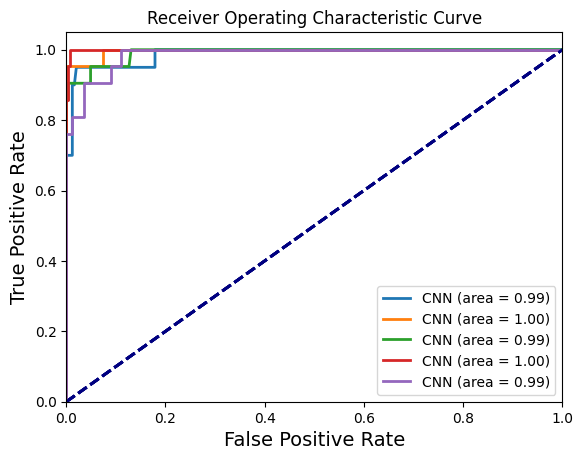

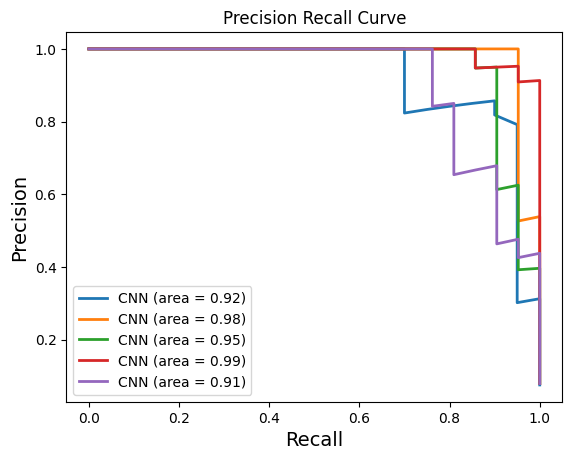

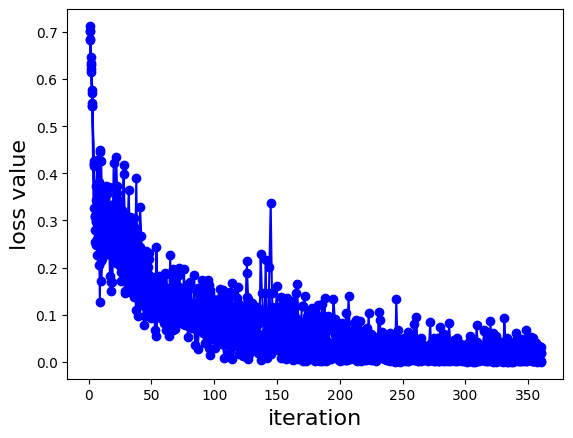

In [69]:
# Compute mean and std of each metric and print them
accuracies, precisions, recalls, f1_scores, roc_aucs, balanced_accuracies = cross_validation(X, y, kfold)

print_performances(accuracies, precisions, recalls, f1_scores, roc_aucs, balanced_accuracies)

#### Hyper-parameters Tuning
Perform Hyper-parameters tuning on the best model (DeepPurpose with CNN drug encoding)

In [73]:
# Perform the cross-validation
def evaluate_model_deep(X_train, y_train, X_val, y_val, X_test, y_test, num_iterations=5, drug_encoding='CNN', mlp_hidden_dims_drug=[32, 16, 8], train_epoch=20, LR=0.001, batch_size=32):
    drug_encoding = 'CNN'
    for i in range(num_iterations):
        # Train model on X_train and y_train using DeepPurpose
        model = train_model_crossval(X_train, y_train, X_test, y_test, X_valid, y_valid, drug_encoding=drug_encoding, mlp_hidden_dims_drug=mlp_hidden_dims_drug, train_epoch=train_epoch, LR=LR, batch_size=batch_size)

        X_val = utils.data_process(X_drug=X_val, y=y_val, drug_encoding=drug_encoding, split_method='no_split', random_seed=SEED_VALUE)

        # Make predictions on the validation set
        y_pred = model.predict(X_val)

        # Convert continuous targets to binary targets using a threshold of 0.5
        y_pred_binary = (np.array(y_pred) > 0.5).astype(int)
        y_val_binary = y_val

        # Calculate evaluation metrics on binary targets
        accuracies.append(accuracy_score(y_val_binary, y_pred_binary))
        precisions.append(precision_score(y_val_binary, y_pred_binary))
        recalls.append(recall_score(y_val_binary, y_pred_binary))
        f1_scores.append(f1_score(y_val_binary, y_pred_binary))

        # Check if there are at least two unique classes in y_val before calculating ROC AUC
        if len(np.unique(y_val)) >= 2:
            roc_aucs.append(roc_auc_score(y_val, y_pred))
        else:
            roc_aucs.append(np.nan)

        balanced_accuracies.append(balanced_accuracy_score(y_val_binary, y_pred_binary))
    
    return accuracies, precisions, recalls, f1_scores, roc_aucs, balanced_accuracies


In [74]:
# Perform StratifiedKFold cross-validation to check better the model performances
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED_VALUE)

accuracies, precisions, recalls, f1_scores, roc_aucs, balanced_accuracies = [], [], [], [], [], []

# Define the parameter grid for grid search
param_grid = {
    'drug_encoding': ['CNN'],
    'mlp_hidden_dims_drug': [[32, 16, 8], [64, 32, 16], [128, 64, 32]],
    'train_epoch': [20, 40, 60],
    'LR': [0.001, 0.01, 0.1],
    'batch_size': [64, 128, 256]
}

In [75]:
# Perform the grid search
best_metric_value = 0.0
best_parameters = None
best_metrics = None

for params in itertools.product(*param_grid.values()):
    drug_encoding, mlp_hidden_dims_drug, train_epoch, LR, batch_size = params

    # Perform cross-validation
    accuracies, precisions, recalls, f1_scores, roc_aucs, balanced_accuracies = cross_validation(X, y, kfold, drug_encoding, mlp_hidden_dims_drug, train_epoch, LR, batch_size)

    # Compute mean balanced accuracy
    mean_balanced_accuracy = np.mean(balanced_accuracies)

    # Check if the current metric value is better than the previous best metric value
    if mean_balanced_accuracy > best_metric_value:
        best_metric_value = mean_balanced_accuracy
        best_parameters = params  # Store the current parameter combination
        best_metrics = {
            'Accuracy': np.mean(accuracies),
            'Precision': np.mean(precisions),
            'Recall': np.mean(recalls),
            'F1 Score': np.mean(f1_scores),
            'ROC AUC': np.mean(roc_aucs),
            'Balanced Accuracy': mean_balanced_accuracy
        }

    # Display the metric value
    print(f"Parameter combination: {params}")
    print(f"Mean Balanced Accuracy: {mean_balanced_accuracy}")
    print()

# Print the best parameters
print("\nBest Parameters:")
for param_name, param_value in zip(param_grid.keys(), best_parameters):
    print(f"{param_name}: {param_value}")

# Print the metrics of the best model configuration
print("\nMetrics of the Best Model Configuration:")
table_metrics = []
for metric_name, metric_value in best_metrics.items():
    table_metrics.append([metric_name, metric_value])

print(tabulate(table_metrics, headers=['Metric', 'Value']))

Drug Property Prediction Mode...
in total: 1064 drugs
encoding drug...
unique drugs: 1064
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 266 drugs
encoding drug...
unique drugs: 266
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 266 drugs
encoding drug...
unique drugs: 266
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using CNN fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69540. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.89989 , AUPRC: 0.32973 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.19707. Total time 0.00055 hours
Validation at Epoch 2 , AUROC: 0.90945 , AUPRC: 0.32413 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.21379. Total time 0.00111 hours
Validation at Epoch 3 , AUROC: 0.93506 , AUPR

In [ ]:
# Get X and y for train, test, val splits again
X_train = train_data['smiles']
y_train = train_data[CLINTOX_TARGET]

X_test = test_data['smiles']
y_test = test_data[CLINTOX_TARGET]

X_valid = valid_data['smiles']
y_valid = valid_data[CLINTOX_TARGET]

Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using CNN fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69235. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.91577 , AUPRC: 0.37138 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.34261. Total time 0.00055 hours
Validation at Epoch 2 , AUROC: 0.93550 , AUPRC: 0.46441 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.16797. Total time 0.00111 hours
Validation at Epoch 3 , AUROC: 0.95095 , AUPR

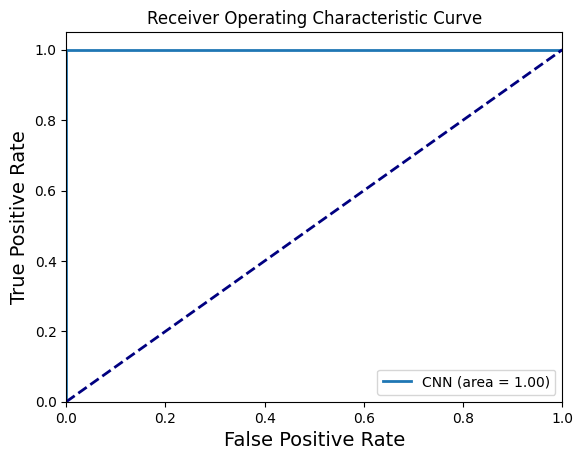

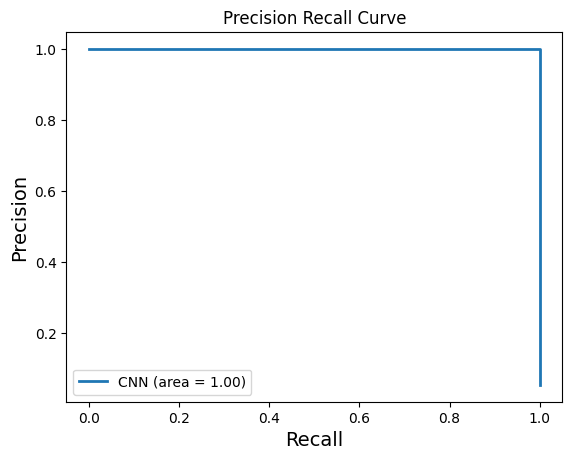

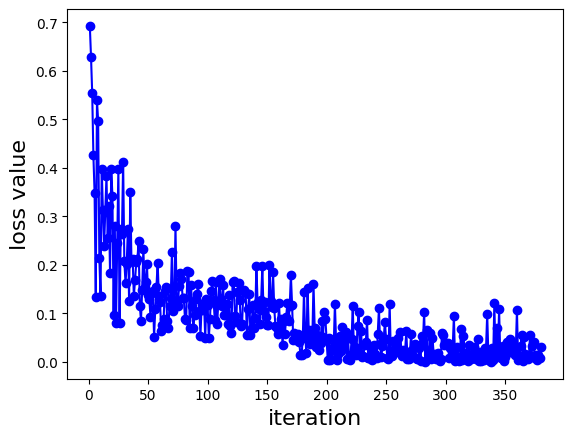

In [ ]:
# Train again the model with the best parameters
drug_encoding, mlp_hidden_dims_drug, train_epoch, LR, batch_size = best_parameters

best_model = train_model_crossval(X_train, y_train, X_test, y_test, X_valid, y_valid, drug_encoding=drug_encoding, mlp_hidden_dims_drug=mlp_hidden_dims_drug, train_epoch=train_epoch, LR=LR, batch_size=batch_size)

Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 3 drugs
encoding drug...
unique drugs: 3
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using CNN fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68064. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.93816 , AUPRC: 0.47231 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.12581. Total time 0.00055 hours
Validation at Epoch 2 , AUROC: 0.94509 , AUPRC: 0.55085 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.32972. Total time 0.00138 hours
Validation at Epoch 3 , AUROC: 0.98454 , AUPRC: 0

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

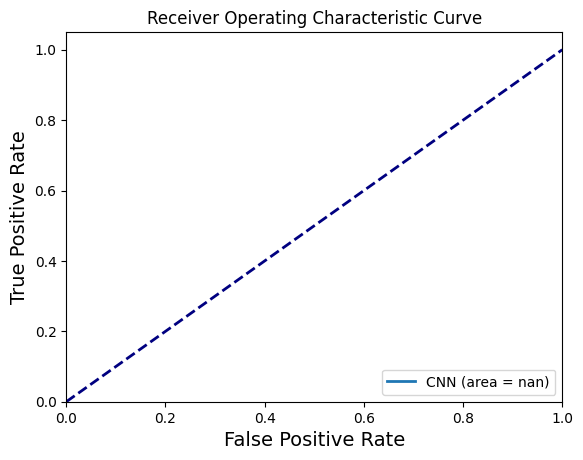

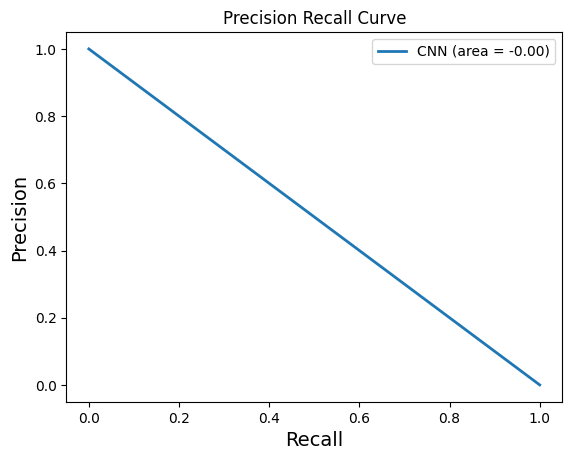

In [ ]:
# Evaluate again the best model on the test set, just to have the metrics mean and standard deviation
accuracies, precisions, recalls, f1_scores, roc_aucs, balanced_accuracies = evaluate_model_deep(X_train, y_train, X_valid, y_valid, X_test, y_test, drug_encoding=drug_encoding, mlp_hidden_dims_drug=mlp_hidden_dims_drug, train_epoch=train_epoch, LR=LR, batch_size=batch_size)
print_performances(accuracies, precisions, recalls, f1_scores, roc_aucs, balanced_accuracies)

#### Explainability

##### Predictions explainability

Counterfactual Explainability

In [ ]:
X_test

In [ ]:
# Get a random molecule from the test set and use it for counterfactual analysis
index = random.choice(range(len(X_test)))
drug = X_test[index]
label = y_test[index]

# Print the randomly sampled drug and label
print("Randomly sampled drug:", drug)
print("Corresponding label:", label)

In [ ]:
# Get model predictions on the test set
# Check if we need to encode the drugs also here
#y_pred = best_model.predict(X_test)

# Convert continuous targets to binary targets using a threshold of 0.5
#y_pred_binary = (np.array(y_pred) > 0.5).astype(int)

In [ ]:
# Check Nitroxoline and a counterfactual graphically
#cfs = exmol.cf_explain(space, 1)
#exmol.plot_cf(cfs)

# The molecules are very similar in structure, and it seems the bond between N and H2N instead of the bond between N and OH is letting the model think the conterfactual is FDA approved

In [ ]:
# Look at more than one counterfactuals
#cfs = exmol.cf_explain(space, 5)
#exmol.plot_cf(cfs)

# The counterfactuals seem to have a very similar structure with respect to the Base molecule.
# It seems that changing what is bond to the "external" N can suggest us if the molecule is predicted 1 or 0.
# The same seem to happen with the bonds with the N+ in the "center". if it has a bond with other atoms it suggests it is predicted as 1.

In [ ]:
#Plot chemical space around example and annotate given examples (PCA 2 components)
#exmol.plot_space(space, cfs)

# From the PCA 2 components representation, the two molecules are quite far from each other.
# The two classes are overlapped, but Nitroxoline seem to be a bit out of the sample space.

# We see that the smallest changes to affect the prediction are: 
# remove the alchool OH bond to the "external" N or substitute it with other atoms, 
# Add bonded atoms to the "central" N+.

In [ ]:
# Explain using substructures 
#exmol.lime_explain(space)
#exmol.plot_descriptors(space)

# From the substructures explanation, It seems that to have a prediction=1 the most important substructure are the presence of an S and if there is an N bonded to at least one H.
# The characteristics that are leading to a prediction=0 instead are: the presence of multiple N atoms, the presence of multiple heteroatoms bonded to at least one H atom, the presence of a heteroatom bonded to amethyl C.

# Looking at the local explanation above, between the Base molecule and Counterfactuals, the substructures indications doesn't give us information to think they are very different and belong to different classes, 
# but again the one before was just a local explanation of 5 counterfactuals.

LIME explanation

In [ ]:
#exmol.lime_explain(space, descriptor_type="ECFP")
#svg = exmol.plot_descriptors(space, return_svg=True)
#skunk.display(svg)
#svg = exmol.plot_utils.similarity_map_using_tstats(space[0], return_svg=True)
#skunk.display(svg)

# from the LIME explanation using ECFP as descriptor type, we  see that there is not a single thing that can direct our prediction, 
# but the presence of a cation/aromatic/methyl group can lead to predicting class 1,
# while the presence of a cation/methyl group can lead to predicting class 0.
# The most important part seem to be the bonds with the N+ atom.
# The differences are not strongly evident, probably because of the model's not excellent performances in generalizing.

##### Applicability Domain